In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from FACS_Sampling.utils import create_adata

sc.set_figure_params(figsize=(8,8), fontsize=15, )

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import warnings
warnings.filterwarnings("ignore")

/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.4 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.3 pynndescent==0.5.11


In [3]:

# Get the file path from the environment variable
file_path_env = os.getenv('MY_FACS_DATA_PATH')
input_file1 = os.path.join(file_path_env,'sara_data',"adata_ref_sara_2M.h5ad")
adata_ref = sc.read_h5ad(input_file1)

In [6]:
import numpy as np
import pandas as pd

def quantile_based_sampling(data, quantile_percentage, accumulation_method='sum'):
    """
    Perform quantile-based sampling on multi-dimensional data.

    :param data: A NumPy array or Pandas DataFrame with multi-dimensional data.
    :param quantile_percentage: The percentage for quantile binning.
    :param accumulation_method: Method to accumulate probabilities ('sum', 'product', 'min', 'max').
    :return: Indices of sampled data points.
    """
    # Convert to DataFrame for ease of processing
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)

    # Calculate quantile bins and probabilities
    quantile_values = data.quantile(np.arange(0, 1 + quantile_percentage, quantile_percentage))
    probabilities = pd.DataFrame(index=data.index, columns=data.columns)

    for feature in data.columns:
        # Assign probabilities inversely proportional to bin length
        for i in range(len(quantile_values) - 1):
            lower_bound = quantile_values.iloc[i][feature]
            upper_bound = quantile_values.iloc[i + 1][feature]
            bin_indices = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)].index
            bin_length = upper_bound - lower_bound
            probabilities.loc[bin_indices, feature] = 1 / bin_length if bin_length > 0 else 1

    # Accumulate probabilities across features
    if accumulation_method == 'sum':
        final_probabilities = probabilities.sum(axis=1)
    elif accumulation_method == 'product':
        final_probabilities = probabilities.product(axis=1)
    elif accumulation_method == 'min':
        final_probabilities = probabilities.min(axis=1)
    elif accumulation_method == 'max':
        final_probabilities = probabilities.max(axis=1)
    else:
        raise ValueError("Invalid accumulation method")

    # Normalize probabilities to sum to 1
    final_probabilities /= final_probabilities.sum()

    # Perform weighted sampling
    sampled_indices = np.random.choice(final_probabilities.index, size=len(data), replace=True, p=final_probabilities)
    
    return sampled_indices, final_probabilities

In [7]:
# Example usage with synthetic data
np.random.seed(0)  # For reproducibility
synthetic_data = np.random.rand(100, 5)  # 100 data points, 5 features
sampled_indices, finals = quantile_based_sampling(synthetic_data, 0.20, accumulation_method='sum')

sampled_indices[:10]  # Display first 10 sampled indices

array([30, 37, 52, 75, 33, 92, 86,  4, 25, 44])

In [11]:
sampled_indices

array([30, 37, 52, 75, 33, 92, 86,  4, 25, 44, 10, 34, 74, 68, 62, 71, 20,
       33, 67, 88, 54, 27,  2, 71,  0, 37, 53, 92,  8, 40,  2, 34, 62, 27,
       20, 11, 57, 69, 67, 94,  0, 64, 60, 59, 96,  1, 69, 82, 51, 33, 79,
        9, 44, 52, 69,  9, 22, 40, 62, 89, 62, 13, 98, 87, 50, 92, 54, 92,
       83, 96, 92,  3, 17, 38, 95, 29, 16, 89, 44, 91, 16, 66, 44,  7, 69,
       24,  3,  6,  6, 91, 74, 90, 67, 52, 30, 99, 36, 47, 37, 97])

In [4]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(adata_ref.X)
X = data_standardized

In [5]:
start_time = time.time()
pca = PCA(n_components=22)
pca.fit(X)
X_pca = pca.transform(X)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
pca.explained_variance_ratio_

Elapsed time: 10.867130041122437 seconds


array([0.29611905, 0.10336761, 0.06817229, 0.06363445, 0.05164509,
       0.04929765, 0.04120547, 0.03920579, 0.0347095 , 0.03352271,
       0.03152928, 0.0287139 , 0.02660708, 0.02371329, 0.0214834 ,
       0.02027838, 0.01780217, 0.01560683, 0.01171355, 0.00882947,
       0.00736901, 0.00547405])

In [6]:
df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'PC4': X_pca[:, 3],
    'PC5': X_pca[:, 4],
    'PC6': X_pca[:, 5],
    'PC7': X_pca[:, 6],
    'PC8': X_pca[:, 7],
    'PC9': X_pca[:, 8],
    'PC10': X_pca[:, 9],
    'PC11': X_pca[:, 10],
    'PC12': X_pca[:, 11],
    'PC13': X_pca[:, 12],
    'PC14': X_pca[:, 13],
    'PC15': X_pca[:, 14],
    'PC16': X_pca[:, 15],
    'PC17': X_pca[:, 16],
    'PC18': X_pca[:, 17],
    'PC19': X_pca[:, 18],
    'PC20': X_pca[:, 19],
    'PC21': X_pca[:, 20],
    'PC22': X_pca[:, 21],
    'Label': list(adata_ref.obs['population'].values) 
})


# TEST

In [7]:
def pca_bin_sample(df, num_pcs=4, seed=12345, n_bins=50, min_single_sample_bins=5000, verbose= False):
    np.random.seed(seed)

    # Ensure num_pcs does not exceed the number of columns in df
    num_pcs = min(num_pcs, df.shape[1])

    # Function to create bins and digitize
    def create_bins_and_digitize(data, n_bins):
        # print(f"Data type: {data.dtype}, Min: {data.min()}, Max: {data.max()}")
        edges = np.linspace(data.min(), data.max(), n_bins + 1)
        bins = np.digitize(data, edges)
        return bins
    
    # Function to compute single sample bins
    def compute_single_sample_bins(df, n_bins):
        bins = [create_bins_and_digitize(df.iloc[:, i], n_bins) for i in range(num_pcs)]

        # Combine bins to form grid cells
        df['grid_cell'] = list(zip(*bins))

        # Group by grid cells and count samples in each
        grouped = df.groupby('grid_cell').size()

        # Return single sample bins
        return grouped[grouped == 1]


    
    
    # Check if number of single-sample bins is below threshold
    single_sample_bins = compute_single_sample_bins(df, n_bins)
    print(f'number of samples with the initial {n_bins} bins in each PC is {len(single_sample_bins)}' )
    while len(single_sample_bins) < min_single_sample_bins:
        # Increase bin size and re-bin if necessary
        n_bins = int(n_bins * 2)
        single_sample_bins = compute_single_sample_bins(df, n_bins)
        if verbose:
            print(len(single_sample_bins))

        
    initial_n_bins = n_bins
    

    # Binary search setup
    low = 1
    # high = initial_n_bins * 2
    high = initial_n_bins * 2
    n_bins = initial_n_bins
    while low <= high:
        n_bins = (low + high) // 2
        single_sample_bins = compute_single_sample_bins(df, n_bins)
        if len(single_sample_bins) > min_single_sample_bins * 1.01:
            high = n_bins - 1
            if verbose:
                print(f'range is  : {low} - {high}.')
        elif len(single_sample_bins) < min_single_sample_bins:
            low = n_bins + 1
            if verbose:
                print(f'range is  : {low} - {high}.')
        else:
            break

    # Get indices from bins with exactly one sample
    single_sample_bins = compute_single_sample_bins(df, n_bins).index
    sampled_indices = df[df['grid_cell'].isin(single_sample_bins)].index
    print(f'number of  PCs: {num_pcs}')
    print(f'number of bins: {n_bins}')
    print(f'number of samples: {len(single_sample_bins)}')
                                
    return sampled_indices, n_bins


## try on the full dataset.

In [8]:
real_df = pd.DataFrame(adata_ref.X, columns=adata_ref.var_names)
real_df['Label'] = list(adata_ref.obs['population'].values)

In [9]:
print(f'********* #full dataset *********')
start_time = time.time()

real_bin_out = pca_bin_sample(df, n_bins=5, num_pcs=22, min_single_sample_bins=200000, verbose=True)[0]

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

********* #full dataset *********
number of samples with the initial 5 bins in each PC is 29484
490332
range is  : 1 - 9.
range is  : 6 - 9.
range is  : 8 - 9.
range is  : 8 - 7.
number of  PCs: 22
number of bins: 8
number of samples: 217768
Elapsed time: 195.28942680358887 seconds


In [10]:
len(real_bin_out)

217768

## try on the pca

In [11]:
def generate_samples(df):
    generated_samples_indices_list = []
    for i in range(21):
        print(f'********* #PCs  is  {i+1}  *********')
        start_time = time.time()

        pca_bin_out = pca_bin_sample(df, n_bins=5, num_pcs=i+1, min_single_sample_bins=5000)[0]

        elapsed_time = time.time() - start_time
        print(f"Elapsed time: {elapsed_time} seconds")
        generated_samples_indices_list.append(pca_bin_out)
        
    return generated_samples_indices_list

In [12]:
gsil = generate_samples(df)

********* #PCs  is  1  *********
number of samples with the initial 5 bins in each PC is 1
number of  PCs: 1
number of bins: 136320
number of samples: 5039
Elapsed time: 26.255855560302734 seconds
********* #PCs  is  2  *********
number of samples with the initial 5 bins in each PC is 4
number of  PCs: 2
number of bins: 368
number of samples: 5040
Elapsed time: 23.61256241798401 seconds
********* #PCs  is  3  *********
number of samples with the initial 5 bins in each PC is 15
number of  PCs: 3
number of bins: 71
number of samples: 5068
Elapsed time: 18.34995198249817 seconds
********* #PCs  is  4  *********
number of samples with the initial 5 bins in each PC is 46
number of  PCs: 4
number of bins: 31
number of samples: 4895
Elapsed time: 18.450636625289917 seconds
********* #PCs  is  5  *********
number of samples with the initial 5 bins in each PC is 92
number of  PCs: 5
number of bins: 21
number of samples: 5454
Elapsed time: 22.810554265975952 seconds
********* #PCs  is  6  ******

In [10]:
ad_ref = adata_ref.copy()
ad_ref.X = X_pca

In [11]:
# Generate another batch of data for fsbs
from FACS_Sampling.methods.methods import bin_sample
start_time = time.time()

seed = 123
np.random.seed(seed)
new_seed = np.random.randint(100000)
# %time
ps, _ = bin_sample(ad_ref, n_bins=25, s_size=500, seed=new_seed)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(len(ps))

Elapsed time: 367.7998390197754 seconds
211559


In [12]:
# Generate another batch of data for fsbs
from FACS_Sampling.methods.methods import sample_random
start_time = time.time()

seed = 123
np.random.seed(seed)
new_seed = np.random.randint(100000)
rs = sample_random(ad_ref, s_size=217768, seed=new_seed)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.3511383533477783 seconds


In [13]:
rs.shape

(217768,)

In [ ]:
start_time = time.time()

# Compute PCs.
from fbpca import pca
U, s, Vt = pca(X, k=22) # E.g., 22 PCs.
X_dimred = U[:, :22] * s[:22]
# Now, you are ready to sketch!

# Sketch.
from geosketch import gs
N = 217768 # Number of samples to obtain from the data set.
sketch_index = gs(X_dimred, N, replace=False)

X_sketch = X_dimred[sketch_index]
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

#### In the next cell I am trying to use same PCs as I was using in our method to see the differences in the performance

In [16]:
start_time = time.time()

# Compute PCs.
from fbpca import pca
k = 4  # E.g., 22 PCs.
U, s, Vt = pca(X, k=k) 
X_dimred = U[:, :k] * s[:k]
# Now, you are ready to sketch!

# Sketch.
from geosketch import gs
N = 5320 # Number of samples to obtain from the data set.
sketch_index = gs(X_dimred, N, replace=False)

X_sketch = X_dimred[sketch_index]
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc

def plot_improved_population_distribution(adata_list, labels, adata_ref):
    # Create a DataFrame to hold the count data
    pop_counts = pd.DataFrame({
        label: adata.obs['population'].value_counts(normalize=False) #* 100
        for adata, label in zip(adata_list, labels)
    })

    # Sort the populations based on the counts in adata_ref
    ref_order = adata_ref.obs['population'].value_counts().index
    pop_counts = pop_counts.reindex(ref_order)

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    n = len(pop_counts.columns)
    bar_width = 0.8 / n
    indices = np.arange(len(pop_counts))

    for i, label in enumerate(labels):
        ax.bar(indices + i * bar_width, pop_counts[label], bar_width, label=label)

    # Improve the aesthetics
    ax.set_xlabel('Population', fontsize=12)
    ax.set_ylabel('Number of samples', fontsize=12)
    ax.set_xticks(indices + bar_width * (n - 1) / 2)
    ax.set_xticklabels(pop_counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## on real data

In [ ]:
plot_improved_population_distribution([adata_ref[gsil[0]], adata_ref[gsil[1]], adata_ref[gsil[2]], adata_ref[gsil[3]],
                                      adata_ref[gsil[4]], adata_ref[gsil[5]], adata_ref[gsil[6]], adata_ref[gsil[7]]],
                                      ['1PC', '2PC', '3PC', '4PC', '5PC', '6PC', '7PC', '8PC'], adata_ref)

In [38]:
len(real_bin_out)

9993

In [58]:
rs = np.random.randint(0, 2000000, size=5454)

In [59]:
sub_real = np.random.choice(real_bin_out, 5454)

In [60]:
adata_ref[rs]

View of AnnData object with n_obs × n_vars = 5454 × 22
    obs: 'old_index', 'unique_id', 'sex', 'age', 'subtype', 'type', 'blastcount', 'survival_sorter', 'run', 'sample_id', 'alignment_mc_aligned', 'flowsom_cluster', 'flowsom_metacluster', 'population'

In [22]:
print(len(rs), len(sketch_index), len(real_bin_out) )

217768 217768 217768


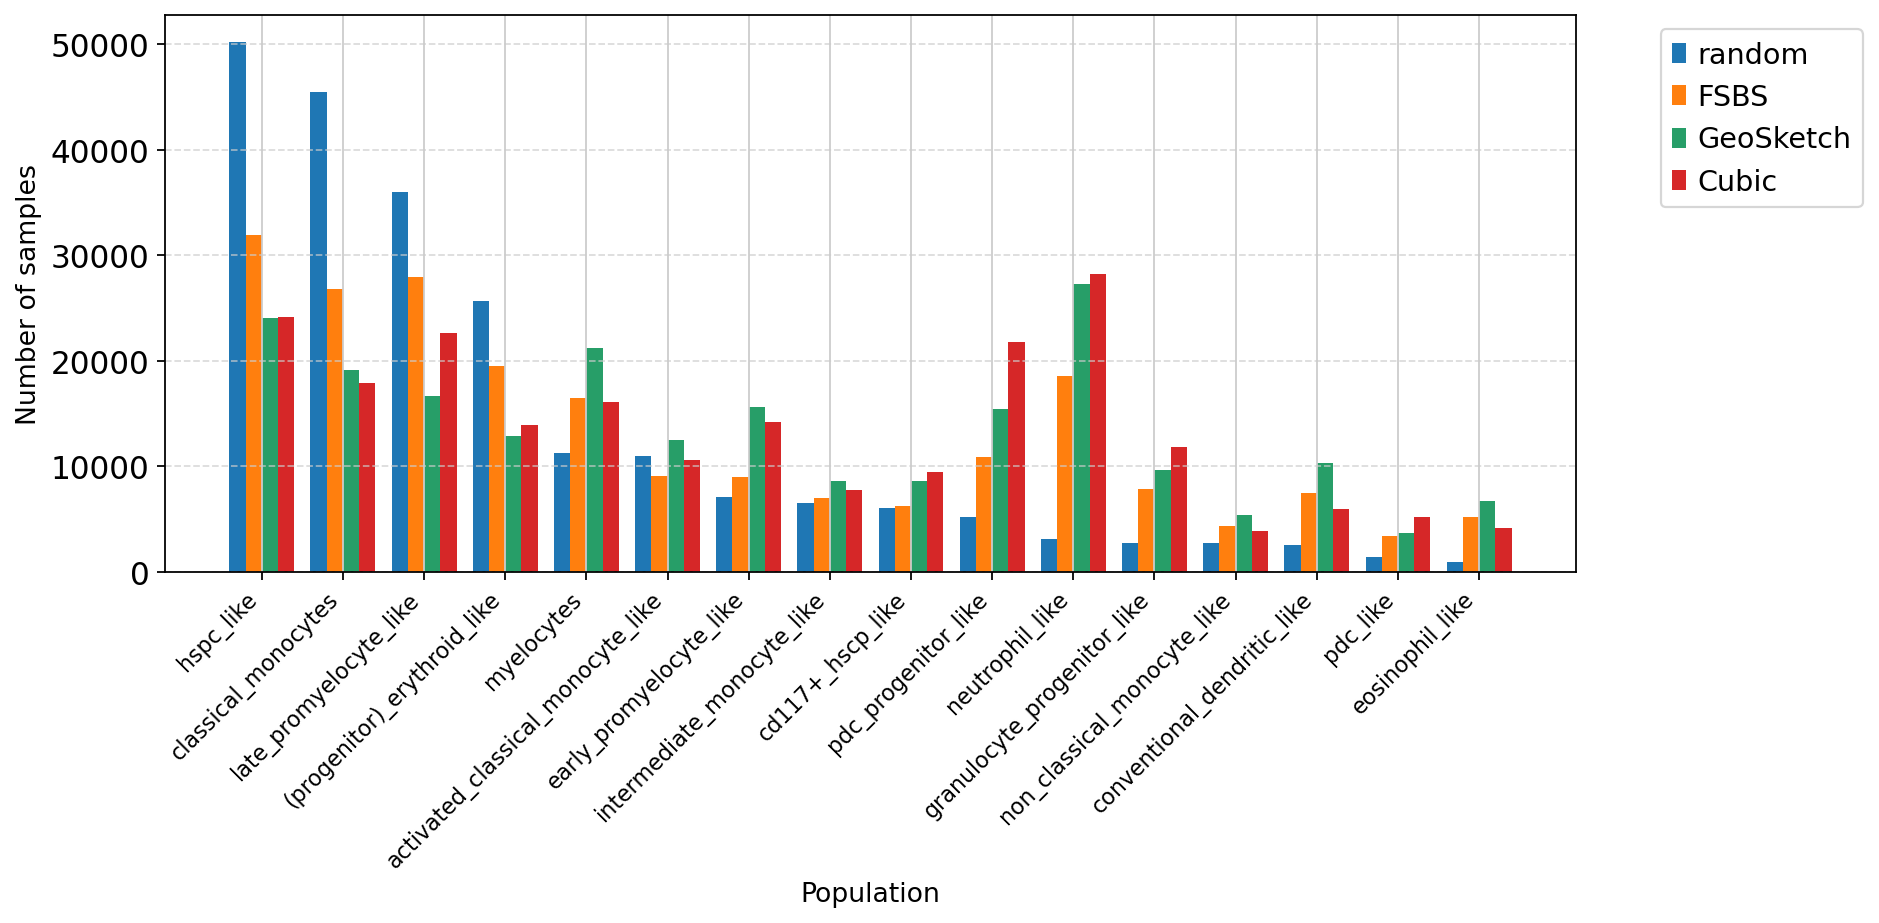

In [19]:
plot_improved_population_distribution([adata_ref[rs], adata_ref[ps], adata_ref[sketch_index], adata_ref[real_bin_out]],
                                      ['random', 'FSBS', 'GeoSketch', 'Cubic'], adata_ref)

In [53]:
len(gsil[4])

5454

## on pcas

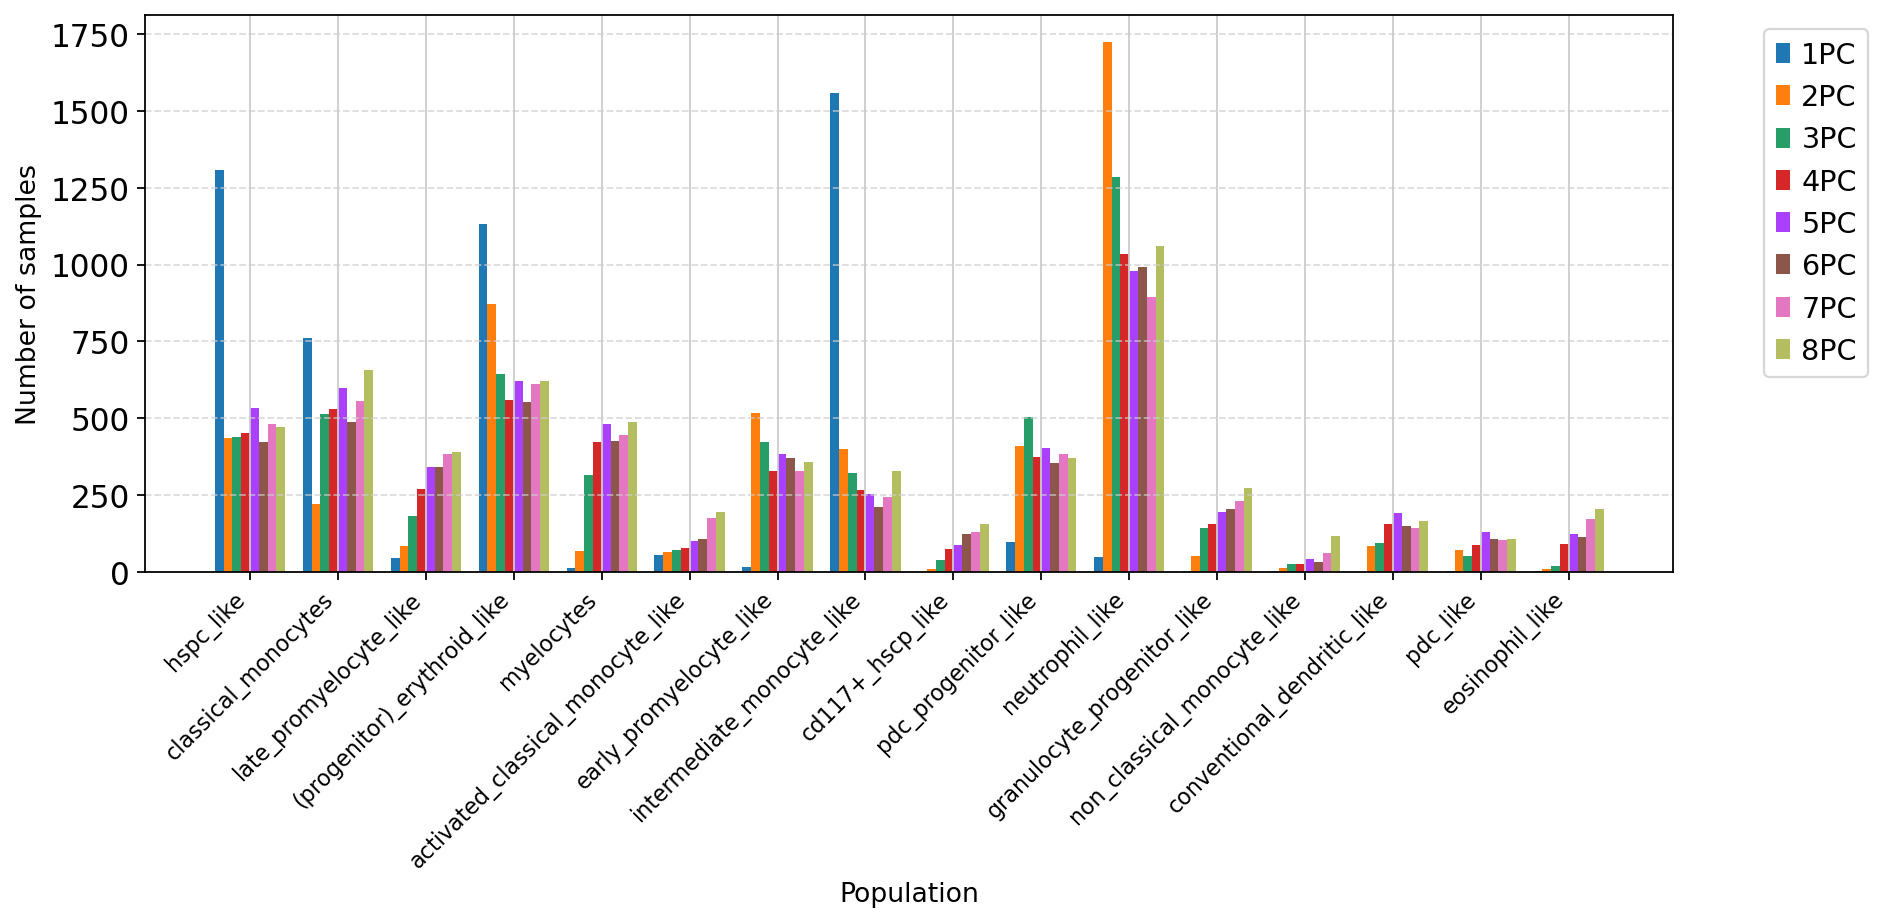

In [15]:
plot_improved_population_distribution([adata_ref[gsil[0]], adata_ref[gsil[1]], adata_ref[gsil[2]], adata_ref[gsil[3]],
                                      adata_ref[gsil[4]], adata_ref[gsil[5]], adata_ref[gsil[6]], adata_ref[gsil[7]]],
                                      ['1PC', '2PC', '3PC', '4PC', '5PC', '6PC', '7PC', '8PC'], adata_ref)

In [16]:
min([ len(_) for _ in gsil])

1549

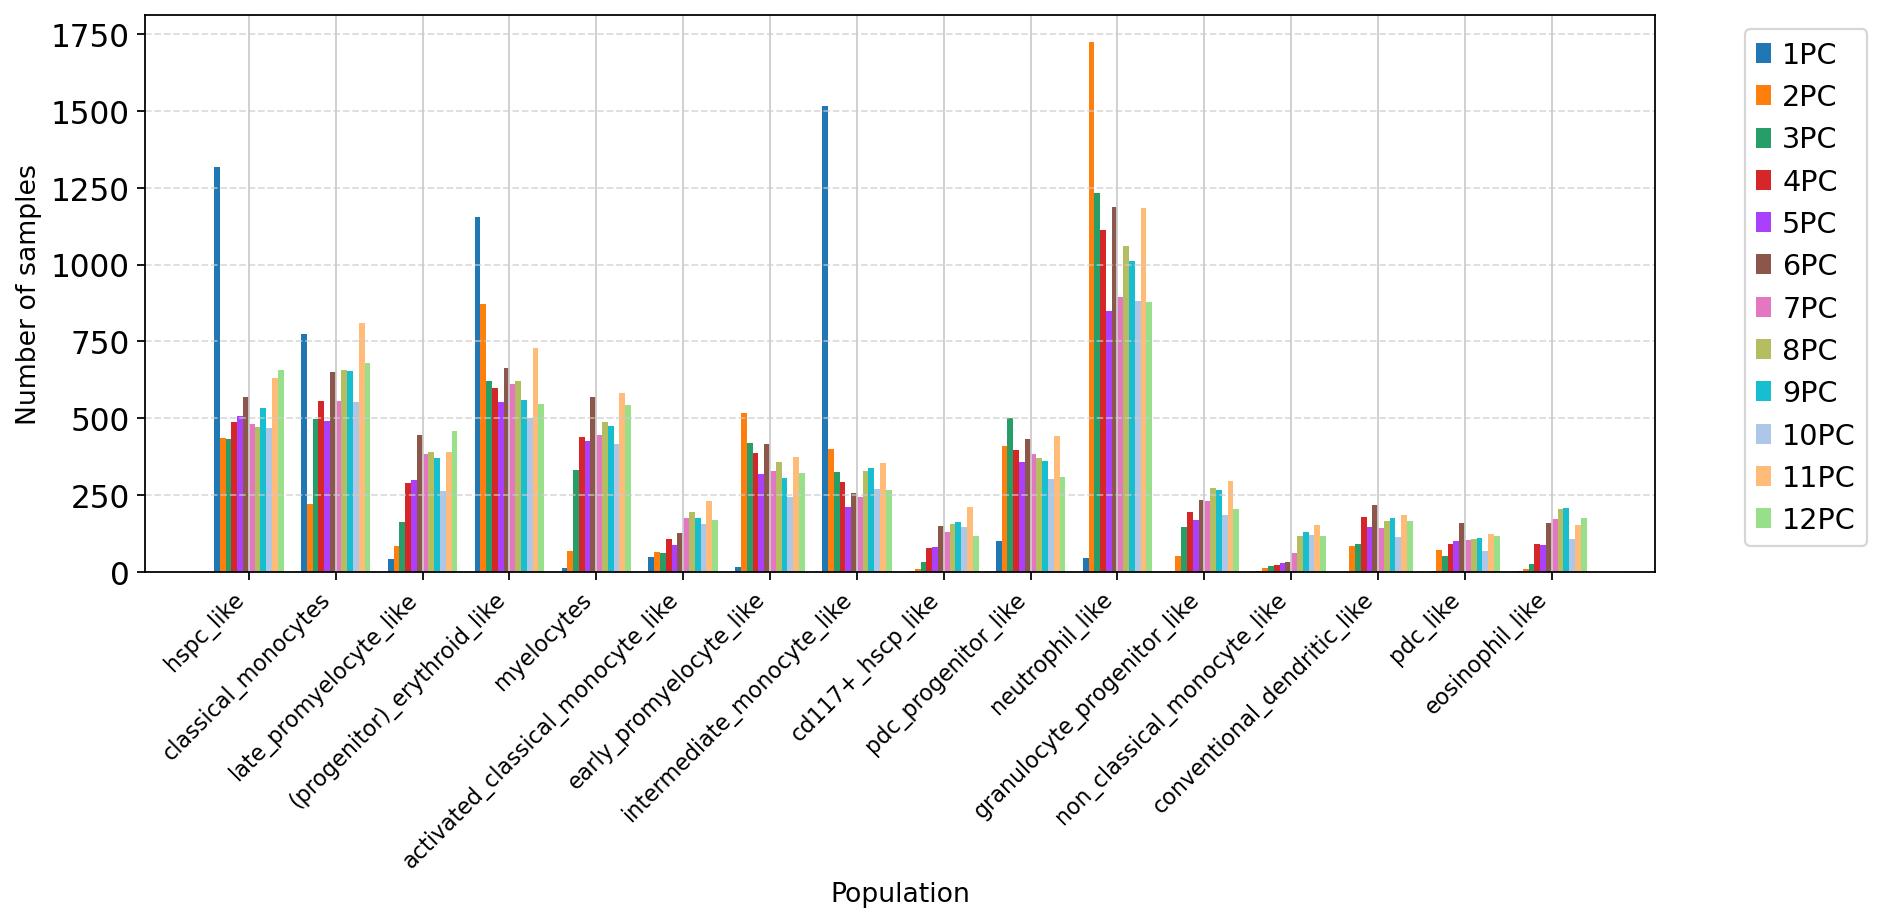

In [70]:
plot_improved_population_distribution([adata_ref[gsil[0]], adata_ref[gsil[1]], adata_ref[gsil[2]], adata_ref[gsil[3]],
                                      adata_ref[gsil[4]], adata_ref[gsil[5]], adata_ref[gsil[6]], adata_ref[gsil[7]],
                                      adata_ref[gsil[8]], adata_ref[gsil[9]], adata_ref[gsil[10]], adata_ref[gsil[11]]],
                                      ['1PC', '2PC', '3PC', '4PC', '5PC', '6PC', '7PC', '8PC', '9PC', '10PC', '11PC', '12PC'], adata_ref)

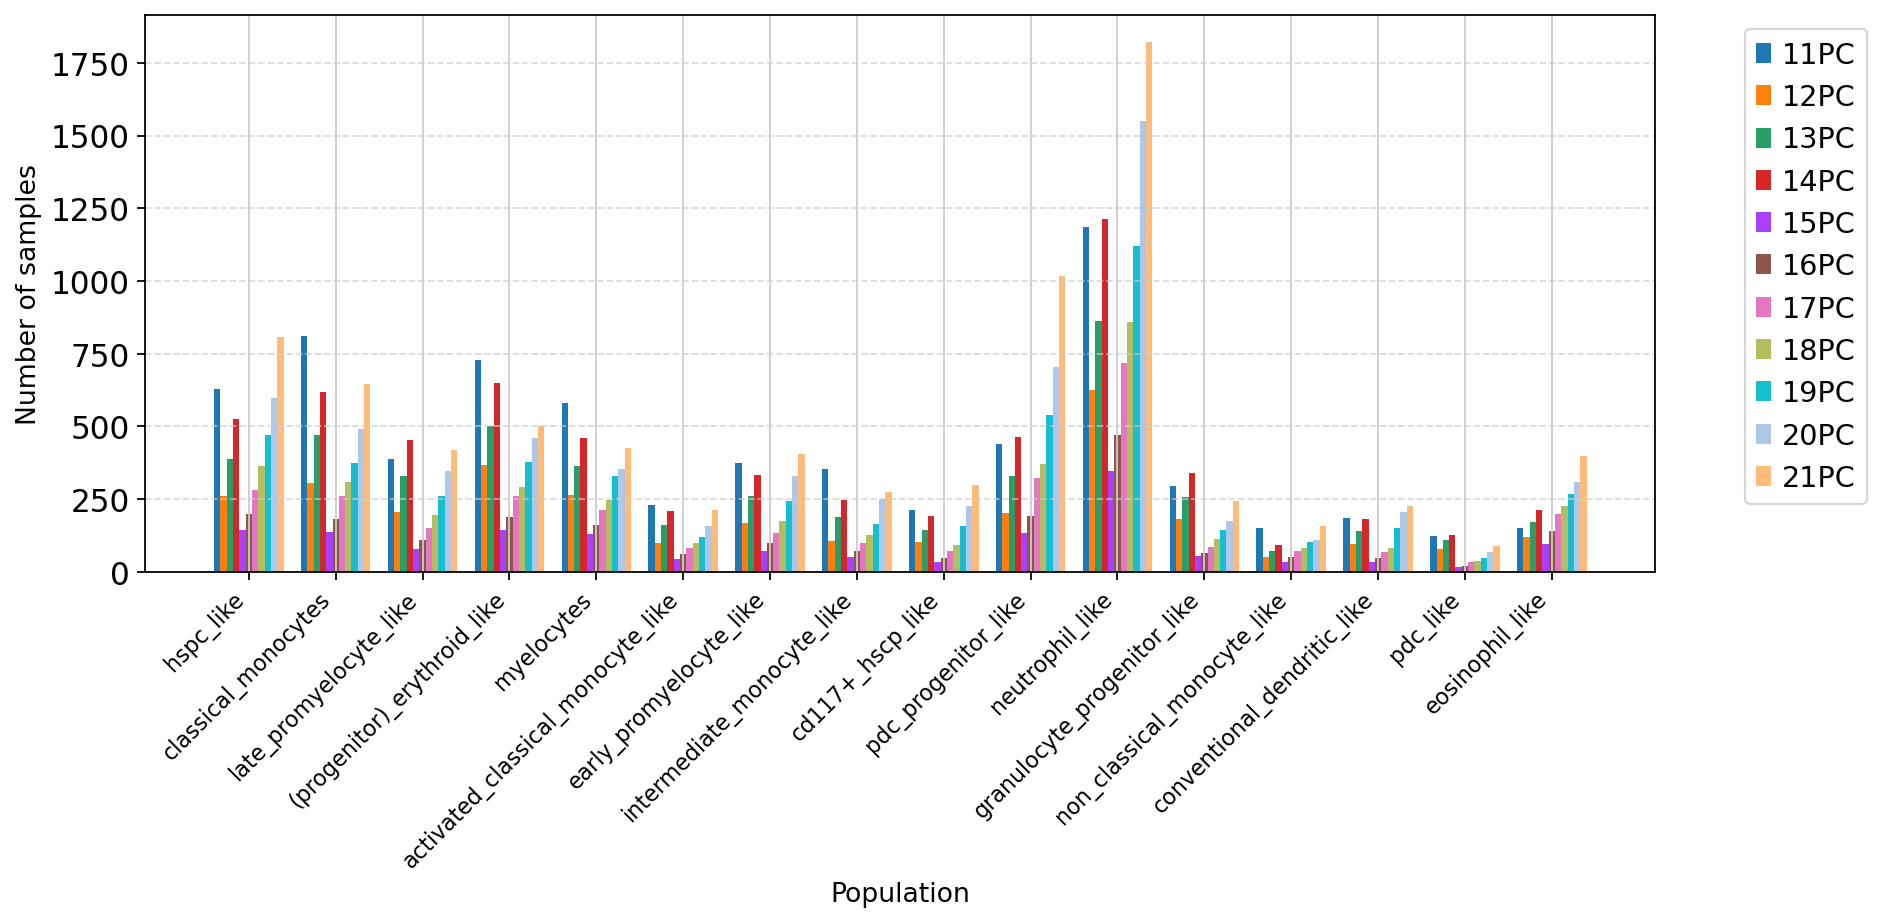

In [23]:
plot_improved_population_distribution([adata_ref[gsil[10]], adata_ref[gsil[11]], adata_ref[gsil[12]], adata_ref[gsil[13]],
                                      adata_ref[gsil[14]], adata_ref[gsil[15]], adata_ref[gsil[16]], adata_ref[gsil[17]],
                                      adata_ref[gsil[18]], adata_ref[gsil[19]], adata_ref[gsil[20]]],
                                      ['11PC', '12PC', '13PC', '14PC', '15PC', '16PC', '17PC', '18PC', '19PC', '20PC', '21PC'], adata_ref)

normalizing counts per cell
    finished (0:00:00)


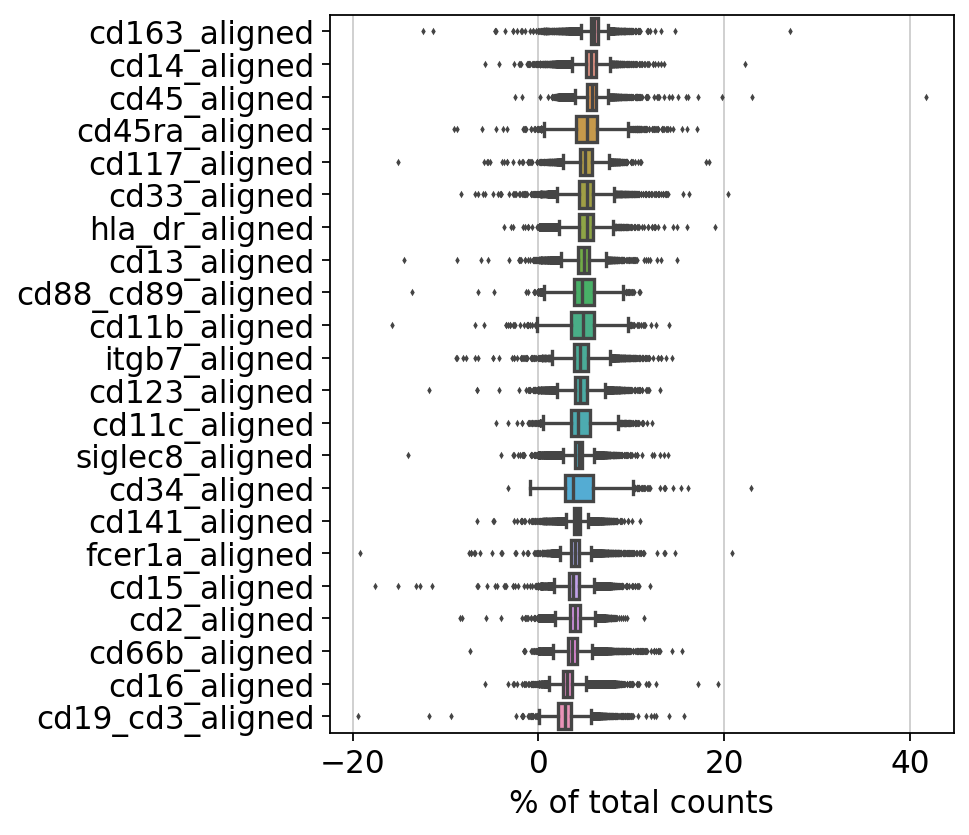

In [7]:
sc.pl.highest_expr_genes(adata_fsbs, n_top=22, )